# Black Hole Growth Revisited

## 1. The Plummer Sphere

Let's revisit the idea of a supermassive black hole growing in its host galaxy -- feeding nice and slowly from, say, gas at the centre of the galaxy -- <i>adiabatically</i>.  

We'll run through the details later, but for now, let's set up our model of the host galaxy.  To keep things simple (maybe too simple), let's use the Plummer Sphere, which has a potential given by
$$
\Phi(r) = - \frac{GM}{a} \frac{1}{\sqrt{1 + r^2/a^2}}
$$
and a density by
$$
\rho(r) = \frac{3}{4\pi} \frac{M}{a^3} \frac{1}{(1 + r^2/a^2)^{5/2}},
$$
where $M$ is the total mass of the system and $a$ is a characteristic scale radius.  Finally, we need the mass distribution function (DF)$f(\mathbf{x}, \mathbf{v})$ for this model -- that is, the mass of the system in the small volume $d^3 \mathbf{x}$ centered on $\mathbf{x}$ and having velocities in the range $d^3 \mathbf{v}$ centered on $\mathbf{v}$ is given by $f(\mathbf{x}, \mathbf{v})\, d^3\mathbf{x} d^3\mathbf{v}$.  Now, for a system that is spherically symmetric, it turns out we can write the DF in terms of energy $E$ and angular momentum $J$ only (see Binney and Tremaine section 4.4), and for the Plummer model the DF is
$$
f(E, J) = \frac{24 \sqrt{2}}{7 \pi^3} \frac{a^2}{G^5 M^4} (-E)^{7/2}.
$$

It turns out that everything you need to know about the system is contained in the DF.  For example, you can calculate the denisty from it:
$$
\rho(r) = 4 \pi \int_{\Phi(r)}^{\Phi(\infty)} dE \int_0^{J_\text{max}} \frac{J\, dJ}{r^2 v_r} \, f(E),
$$
where 
$$
J_\text{max} = \sqrt{2r^2 (E - \Phi)}
$$
and 
$$
v_r = \sqrt{2 (E - \Phi) - J^2 / r^2},
$$
as you'd expect for a system that is spherically symmetric.

In all that follows, we take units such that $G = M = a = 1$.  This is just to simplify things; we can always scale our system later to whatever size we like.

### Density and Potential

To start, let's plot the density and potential for the Plummer sphere.  Remember, this is our model for a galaxy that hosts a black hole!

We'll plot the density on a log-log scale, but the for potential we'll only put the $x$-axis on a log scale (since it's negative).  Before we even do that, though, let's set up our environment and make sure it looks good.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import scipy
from numba import njit, vectorize, float64

rc('text.latex',preamble='\\usepackage{libertine}\n\\usepackage[libertine]{newtxmath}')
rc('font',**{'family':'serif','serif':['Linux Libertine O']}, size=18)
rc('text', usetex=True)

# we'll need this later, and it's a little better than trapz
@njit
def int_simpson(f, x):
    """
    Simpson rule for irregularly spaced data.

        Parameters
        ----------
        x : list or np.array of floats
                Sampling points for the function values
        f : list or np.array of floats
                Function values at the sampling points

        Returns
        -------
        float : approximation for the integral
    """
    N = len(x) - 1
    h = np.diff(x)
   
    result = 0.0
    for i in range(1, N, 2):
        if h[i] != 0.0:
            hph = h[i] + h[i - 1]
            result += f[i] * ( h[i]**3 + h[i - 1]**3 + 3. * h[i] * h[i - 1] * hph ) / ( 6 * h[i] * h[i - 1] )
            result += f[i - 1] * ( 2. * h[i - 1]**3 - h[i]**3 + 3. * h[i] * h[i - 1]**2) / ( 6 * h[i - 1] * hph)
            result += f[i + 1] * ( 2. * h[i]**3 - h[i - 1]**3 + 3. * h[i - 1] * h[i]**2) / ( 6 * h[i] * hph )

    if (N + 1) % 2 == 0:
        if h[N] != 0.0:
            result += f[N] * ( 2 * h[N - 1]**2 + 3. * h[N - 2] * h[N - 1]) / ( 6 * ( h[N - 2] + h[N - 1] ) )
            result += f[N - 1] * ( h[N - 1]**2 + 3*h[N - 1]* h[N - 2] ) / ( 6 * h[N - 2] )
            result -= f[N - 2] * h[N - 1]**3 / ( 6 * h[N - 2] * ( h[N - 2] + h[N - 1] ) )
    return result

Now the plots.  We'll define functions for the density and potential since they might be useful later.

In [78]:
# remember M = a = 1!
def density(r):
    return 3 / 4 / np.pi * np.power(1 + r**2, -5/2)

def potential(r):
    return -np.power(1 + r**2, -1/2)

@vectorize([float64(float64, float64)])
def distribution_function(E, J):
    return 24 * np.sqrt(2) / 7 / np.pi**3 * np.power(-E, 7/2)

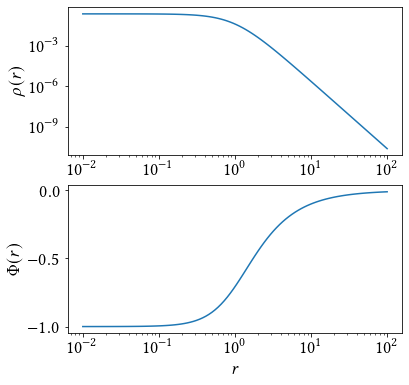

In [9]:
ri = np.logspace(-2.0, 2.0, 100)
rhoi = density(ri)
phii = potential(ri)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(2,1,1)
ax.set_xlabel("r")
ax.set_ylabel(r"$\rho(r)$")
ax.loglog(ri, rhoi)

ax = fig.add_subplot(2,1,2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\Phi(r)$")
ax.semilogx(ri, phii)

plt.savefig("fig_density_potential.pdf", bbox_inches="tight")


### Velocity Moments

We can also calculate the average radial velocity (and any other velocity moment) from the DF:
$$
\langle v_r^m v_t^n \rangle = \frac{4\pi}{\rho} \int_{\Phi(r)}^{\Phi(\infty)} dE \int_0^{J_\text{max}} \frac{J\, dJ}{r^2 v_r} \, f(E) \, v_r^m v_t^n.
$$
For the Plummer model, we get
$$
\langle v_r^2 \rangle = \frac{1}{6} \frac{1}{ (1 + r^2)^{1/2}},
$$
and
$$
\langle v_t^2 \rangle = \frac{1}{3} \frac{1}{ (1 + r^2)^{1/2}}.
$$
Notice that these expressions are pretty similar -- the tangential velocity is twice the radial.  That means that the so-called *anisotropy parameter* 
$$
\beta = 1 - \frac{\langle v_t^2 \rangle}{2\langle v_r^2 \rangle},
$$
which measures the amount of, well, anisotropy in the system, is zero.  That makes sense, since the Plummer sphere is in fact isotropic in velocity.

In [10]:
def average_radial_velocity_squared(r):
    return 1.0/6.0 * np.power(1 + r**2, -1/2)

def average_tangential_velocity_squared(r):
    return 1.0/3.0 * np.power(1 + r**2, -1/2)

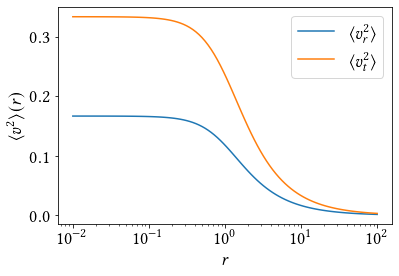

In [11]:
vr2 = average_radial_velocity_squared(ri)
vt2 = average_tangential_velocity_squared(ri)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\langle v^2 \rangle (r)$")
ax.semilogx(ri, vr2, label=r"$\langle v_r^2 \rangle$")
ax.semilogx(ri, vt2, label=r"$\langle v_t^2 \rangle$")
ax.legend()

plt.savefig("fig_vr_vt.pdf", bbox_inches="tight")

## 2. Calculations on a Grid

The algorithm to grow a black hole will require us to calculate all quantities on a series of grids.  For example, the radial grid is our main one -- we'll have it go from $r_0 = r_\text{min}$ to $r_{N-1} = r_\text{max}$ in $N$ equal steps in log spacing, just like above.  But we'll have $r_\text{min}$ and $r_\text{max}$ be a little smaller and bigger to get more accuracy.

However, we also need to calculate the energy $E$ and angular momentum $J$ in a grid, too.  For a given radial grid, the energy will be 
$$
E_i = \Phi(r_i);
$$
that is, it will take on values of the gravitational potential energy.  The angular momentum, for each value of $E_i$ and radius $r_j$, varies from $J_0 = 0$ to $J_{N_J -1} = J_\text{max}(r, E)$.  Notice that I'm using $N_J$ grid points for angular momentum (there's no reason for it to be the same as the energy or radial points, and we'll save some computational time if we make it smaller). 

In [53]:
N = 801
Nj = 801

# radial grid
rmin = -4.0
rmax = 4.0
r_grid = np.logspace(rmin, rmax, N)
phi_grid = potential(r_grid)
rho_grid = density(r_grid)

# energy grid
E_grid = phi_grid

# df on the energy and angular momentum grids
f_grid = np.zeros((N, Nj))
for i in range(N):
    for j in range(Nj):
        f_grid[i, j] = distribution_function(E_grid[i], 0)

As a test calculation, let's try evaluating the density $\rho(r)$ directly from the distribution function. Recall that the integral is
$$
\rho(r) = 4 \pi \int_{\Phi(r)}^{\Phi(\infty)} dE \int_0^{J_\text{max}} \frac{J\, dJ}{r^2 v_r} \, f(E, J).
$$

Let's try calculating this on the grid. Here's the steps:

1. Loop over the radii in our grid (that's the i loop) so we can integrate the energy integral for each value of r[i]

2. Loop over energies next -- that's the j loop.  We'll do the angular momentum integral for each value of E[j], so we first need $J_\text{max}$. 

3. Then we calculate $v_r$ (see above), which we write as
   $$
   v_r = \frac{1}{r} \sqrt{J_\text{max}^2 - J^2}.
   $$
   This happens in a loop over angular momentum (the k loop).
   
4. Then the integrand for the angular momentum integral, which is 
   $$
   g(r, E, J) = \frac{J}{r^2 v_r} f(E, J).
   $$

5. Next, we calculate the energy integrand, which is just
    $$ 
    h(r, E) = \int g(E, J) \, dJ,
    $$
    where the integral is taken over all values in the array for $g(E)$.

6. Finally, the density is
    $$
    \rho(r) = 4 \pi \int h(r, E), dE.
    $$

Here's the code:

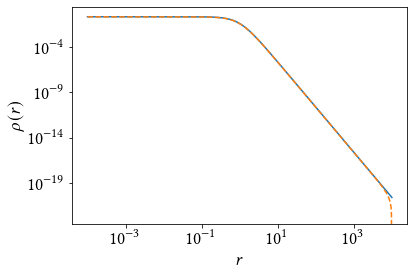

In [66]:
@njit
def calc_density(r, phi, f):
    """
    Calculate the density of the system on a grid based on the potential and 
    distribution function.
    """
    
    N = f.shape[0]
    Nj = f.shape[1]
    
    E = phi
    
    rho = np.zeros(N)
    
    # loop over radius
    for i in range(N):
        
        # placeholder for energy integral
        h = np.zeros(N)
        
        # loop over energy
        for j in range(N):
            
            jmax2 = 2 * r[i]**2 * (E[j] - phi[i])
            if jmax2 > 0:
                jmax = np.sqrt(jmax2)
            else:
                jmax = 0
            
            J = np.linspace(0, jmax, Nj)
            
            g = np.zeros(Nj)
            for k in range(Nj):
                vr = 1.0 / r[i] * np.sqrt(jmax**2 - J[k]**2)
                if vr > 0:
                    g[k] = J[k] / r[i] / r[i] / vr * f[j, k]
                else:
                    g[k] = 0.0
                    
            # do the angular momentum integral
            h[j] = int_simpson(g, J)#np.trapz(g, J)
        
        # then the energy integral
        rho[i] = 4.0 * np.pi * int_simpson(h, E)
    
    return rho

rho_grid_check = calc_density(r_grid, phi_grid, f_grid)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)
plt.loglog(r_grid, rho_grid)
plt.loglog(r_grid, rho_grid_check, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\rho(r)$")

plt.savefig("fig_density_grid.pdf", bbox_inches="tight")

That's not too bad -- we're off a bit at the tail end, since the grid is fixed and we lose accuracy as the number of points where $\sqrt{E - \Phi}$ is real gets smaller.

### The Potential

While we're calculating quantities on a grid, let's try the potential of the system, which we can compute from the density (see Binney and Tremaine, p. 36):
$$
\Phi(r) = -4 \pi G \left[ \frac{1}{r} \int_0^r \rho(r') r'^2 dr' + \int_r^\infty \rho(r') r' dr'  \right].
$$

This is simpler than the density, since we just need one loop over the radius.  We'll also include the possibility of a central point mass -- that's the black hole we'll eventually want to grow.

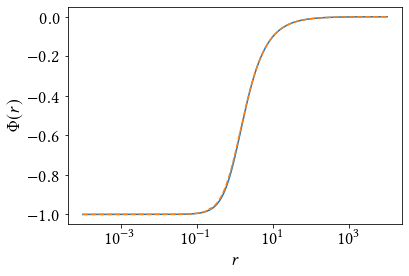

In [67]:
@njit
def calc_potential(r, rho, mass):
    """
    Calculate the density of the system on a grid based on the potential and 
    distribution function.
    """
    
    N = len(r)
    
    rho_r = rho * r
    rho_r2 = rho * r * r
    
    phi = np.zeros(N)
    for i in range(N):
        g1 = int_simpson(rho_r2[0:i], r[0:i])
        g2 = int_simpson(rho_r[i:N-1], r[i:N-1])
        
        phi[i] = -4.0 * np.pi * (g1 / r[i] + g2) - mass / r[i]

    return phi

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)
phi_grid_check = calc_potential(r_grid, rho_grid, 0)
plt.semilogx(r_grid, phi_grid)
plt.semilogx(r_grid, phi_grid_check, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\Phi(r)$")

plt.savefig("fig_potential_grid.pdf", bbox_inches="tight")    

### The Radial Action

Now for a tricky one -- the radial action, defined as
$$
I_r = 2 \int_{r_-}^{r_+} v_r \, dr,
$$
where $r_-$ and $r_+$ are the turning points of the orbit -- where $v_r$ goes to zero.

In [68]:
@njit
def calc_radial_action(r, phi):
    """
    Calculate the radial action of the system on a grid.
    """   
    
    E = phi
    vr = np.zeros(N)
    Ir = np.zeros((N, Nj))
        
    # energy loop
    for j in range(N):
        
        # first find the largest value of Jmax with this energy by looping
        # over all radii
        jmax_max = 0.0
        for i in range(N):
            jmax2 = 2 * r[i]**2 * (E[j] - phi[i])
            if jmax2 > jmax_max**2:
                jmax_max = np.sqrt(jmax2)
            
        # now set the angular momentum to go from 0 to jmax_max
        J = np.linspace(0, jmax_max, Nj)
        
        # angular momentum loop
        for k in range(Nj):
            
            # radius loop to perform integral
            for i in range(N):
                                    
                vr2 = 2 * (E[j] - phi[i]) - J[k]**2 / r[i]**2
                if vr2 > 0:
                    vr[i] = np.sqrt(vr2)
                else:
                    vr[i] = 0
            Ir[j, k] = 2 * int_simpson(vr, r)
    
    return Ir

ir_grid = calc_radial_action(r_grid, phi_grid)



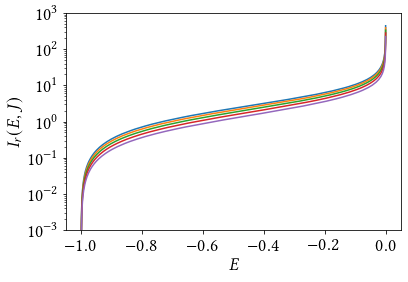

In [70]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)
plt.semilogy(E_grid, (ir_grid[:, 0]))
plt.semilogy(E_grid, (ir_grid[:, 100]))
plt.semilogy(E_grid, (ir_grid[:, 200]))
plt.semilogy(E_grid, (ir_grid[:, 300]))
plt.semilogy(E_grid, (ir_grid[:, 400]))
ax.set_xlabel(r"$E$")
ax.set_ylabel(r"$I_r(E, J)$")
ax.set_ylim(1e-3, 1e3)

plt.savefig("fig_radial_action_grid.pdf", bbox_inches="tight")

### The Velocity Moments

Finally, we'll need to calculate the velocity moments of the system.  Recall from above that they were given by
$$
\langle v_r^m v_t^n \rangle = \frac{4\pi}{\rho} \int_{\Phi(r)}^{\Phi(\infty)} dE \int_0^{J_\text{max}} \frac{J\, dJ}{r^2 v_r} \, f(E) \, v_r^m v_t^n.
$$
We have $v_r$ above, and the tangential velocity is simply
$$
v_t = \frac{J}{r}.
$$

In [74]:
@njit
def calc_velocity_moment(r, rho, phi, f, m, n):
    """
    Calculate the velocity moment <v_r^m v_t^n> of the system on a grid.
    """
    
    N = f.shape[0]
    Nj = f.shape[1]
    
    E = phi
    vel = np.zeros(N)
    
    # loop over radius
    for i in range(N):
        
        # placeholder for energy integral
        h = np.zeros(N)
        
        # loop over energy
        for j in range(N):
            
            jmax2 = 2 * r[i]**2 * (E[j] - phi[i])
            if jmax2 > 0:
                jmax = np.sqrt(jmax2)
            else:
                jmax = 0
            
            J = np.linspace(0, jmax, Nj)
            
            g = np.zeros(Nj)
            for k in range(Nj):
                vr = 1.0 / r[i] * np.sqrt(jmax**2 - J[k]**2)
                vt = J[k] / r[i]
                if vr > 0:
                    g[k] = J[k] / r[i] / r[i] / vr * f[j, k] * np.power(vr, m) * np.power(vt, n)
                else:
                    g[k] = 0.0

            
            # do the angular momentum integral
            h[j] = int_simpson(g, J)
        
        # then the energy integral
        if rho[i] > 0.0:
            vel[i] = 4.0 * np.pi * int_simpson(h, E) / rho[i]
        else:
            vel[i] = 0.0
    
    return vel

vr2_grid = calc_velocity_moment(r_grid, rho_grid, phi_grid, f_grid, 2, 0)
vt2_grid = calc_velocity_moment(r_grid, rho_grid, phi_grid, f_grid, 0, 2)

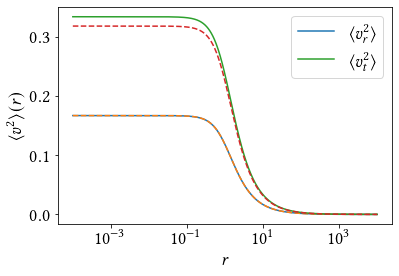

In [75]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)

plt.semilogx(r_grid, average_radial_velocity_squared(r_grid), label=r"$\langle v_r^2 \rangle$")
plt.semilogx(r_grid, vr2_grid, "--")

plt.semilogx(r_grid, average_tangential_velocity_squared(r_grid), label=r"$\langle v_t^2 \rangle$")
plt.semilogx(r_grid, vt2_grid, "--")

ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\langle v^2 \rangle (r)$")
ax.legend()

plt.savefig("fig_vel_moment_grid.pdf", bbox_inches="tight")

For some reason the $\langle v_t^2 \rangle$ calculation is not very accurate -- presumably that integral is trickier to do on the grid.  Increasing the number of grid points does improve things, but not by very much.

## 3. Adiabatic Growth

Now we can turn to the actual process of growing a black hole in our system.  The way we'll do that is by assuming that the growth is adiabatic -- that is, slow enough that the system changes only slightly as the black hole grows.  In particular, we assume that during the growth the angular momentum and the radial action are held constant.  Binney and Tremaine have more details, as does Young's original 1980 paper (and a few others since then).

Here's the algorithm:
1. Given the initial system -- in this case the Plummer sphere we've examined above -- compute the density $\rho(r)$, potential $\Phi(r)$, and radial action $I_r(E, J)$ for the system on the grid.
2. Approximate the final potential $\Phi^*(r)$ by
$$
\Phi^* = \Phi - \frac{M_\text{BH}}{r}
$$
(where I've set $G=1$ remember).
3.  Calculate the radial action $I_r^*(E^*, J)$ for this new potential $\Phi^*$.
4.  Equate the radial actions $I_r^*(E^*, J)$ and $I_r(E, J)$ to find the energy $E$ that has become $E^*$.  The new distribution function will be
$$
f^*(E^*, J) = f(E, J).
$$
5. Compute the density $\rho^*(r)$ and potential $\phi^*(r)$ using the DF $f^*(E^*, J)$.  
6. Go back to step 3 and repeat until the density has converged.

To implement this algorithm, we need one more function -- one that interpolates the radial actions to find the new DF.  Here it is.

In [79]:
@njit
def calc_dfstar(phi, ir, irstar):
    
    N = ir.shape[0]
    Nj = ir.shape[1]
    
    E = phi
    
    fstar = np.zeros((N, Nj))
    
    for i in range(N):
        for k in range(Nj):
            a = irstar[i, k]
            b = np.interp(a, ir[:,k], E)
            
            fstar[i, k] = distribution_function(b, 0)
            
    return fstar

Okay, let's put this all together:

In [82]:
# we'll start with the initial system:  r, rho, phi, Ir, and f on the grid.
# Then grow the BH:

mbh = 0.01

error = 1e-3

rhostar_grid = rho_grid
delta = 1e6
while delta > error:
    print("Calculating potential with BH mass", mbh)
    phistar_grid = calc_potential(r_grid, rhostar_grid, mbh)
    print("Calculating radial action ...")
    irstar_grid = calc_radial_action(r_grid, phistar_grid)
    print("Calculating DF ...")
    fstar_grid = calc_dfstar(phi_grid, ir_grid, irstar_grid)
    print("Calculating density ...")
    rhostar_grid_temp = calc_density(r_grid, phistar_grid, fstar_grid)
    delta = np.max(np.abs(rhostar_grid_temp - rhostar_grid))
    rhostar_grid = rhostar_grid_temp
    print(f"Current delta = {delta}")    


Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating density ...
Current delta = 1783.284217474189
Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating density ...
Current delta = 0.6598249757930716
Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating density ...
Current delta = 0.06935933707950426
Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating density ...
Current delta = 0.017327523559742986
Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating density ...
Current delta = 0.06591142109300563
Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating density ...
Current delta = 0.004644368752224182
Calculating potential with BH mass 0.01
Calculating radial action ...
Calculating DF ...
Calculating densit

(1e-13, 100)

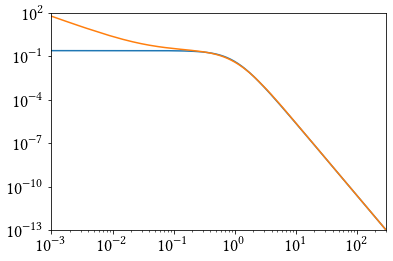

In [89]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)
ax.loglog(r_grid, rho_grid)
ax.loglog(r_grid, rhostar_grid_temp)
ax.set_xlim(1e-3, 300)
ax.set_ylim(1e-13, 100)

Okay, that's a big calculation, but we don't have to run it again unless we want another black hole mass.  Let's take a look at a few things.

In [91]:
vr2star_grid = calc_velocity_moment(r_grid, rhostar_grid, phistar_grid, fstar_grid, 2, 0)
vt2star_grid = calc_velocity_moment(r_grid, rhostar_grid, phistar_grid, fstar_grid, 0, 2)

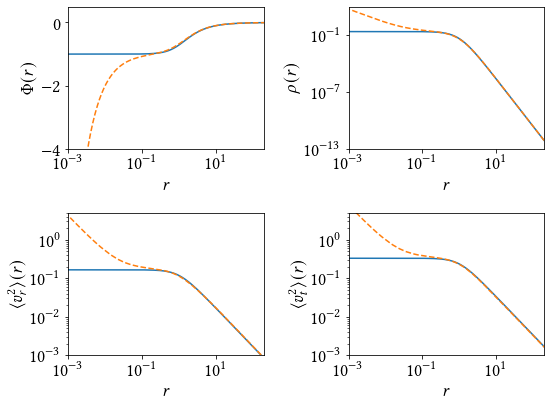

In [112]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(2,2,1)
ax.semilogx(r_grid, potential(r_grid))
ax.semilogx(r_grid, phistar_grid, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\Phi(r)$")
ax.set_ylim(-4, 0.5)
ax.set_xlim(1e-3, 200)

ax = fig.add_subplot(2,2,2)
ax.loglog(r_grid, density(r_grid))
ax.loglog(r_grid, rhostar_grid, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\rho(r)$")
ax.set_xlim(1e-3, 200)
ax.set_ylim(1e-13, 100)

ax = fig.add_subplot(2,2,3)
ax.loglog(r_grid, average_radial_velocity_squared(r_grid))
ax.loglog(r_grid, vr2star_grid, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\langle v_r^2 \rangle (r)$")
ax.set_xlim(1e-3, 200)
ax.set_ylim(1e-3, 5)

ax = fig.add_subplot(2,2,4)
ax.loglog(r_grid, average_tangential_velocity_squared(r_grid))
ax.loglog(r_grid, vt2star_grid, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\langle v_t^2 \rangle (r)$")
ax.set_xlim(1e-3, 200)
ax.set_ylim(1e-3, 5)



/tmp/ipykernel_23060/4173877183.py:5: RuntimeWarning: invalid value encountered in divide
  ax.semilogx(r_grid, 1.0 - vt2star_grid / 2.0 / vr2star_grid, "--")


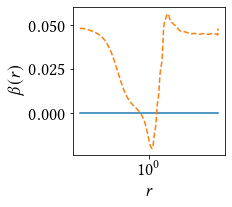

In [114]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(2,2,1)
ax.semilogx(r_grid, 1.0 - average_tangential_velocity_squared(r_grid) / 2.0 / average_radial_velocity_squared(r_grid))
ax.semilogx(r_grid, 1.0 - vt2star_grid / 2.0 / vr2star_grid, "--")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\beta(r)$")

plt.savefig("fig_anisotropy.pdf", bbox_inches="tight")